# Øving 6 - oppgave

**Veiledning:** Fredag 15. mars, 2019, kl 0815-1000.

**Innleveringsfrist:** Fredag 22. mars, 2019, kl 13:00.

I denne øvingen skal du lage en ODE-løser med skrittlengdekontroll. Den skal kunne løse generelle startverdiproblemer av formen

$$
      y' = f(t,y),\quad y(t_0)=y_0\quad\text{for}\ t\in[t_0,t_{end}]
$$

Man lager en funksjon som tar følgende input
* t0: Startpunktet (venstre endepunkt)
* tend: Sluttpunktet (høyre endepunkt)
* y0: Den gitte initialverdien i t0
* f: En funksjon som beskrevet nedenfor
* h0: En omtrentlig første tidsskrittlengde
* tol: En brukerspesifisert toleranse for lokalfeil

Funksjonen returnerer
* T: et numpy array med alle [t0,t1,...,tend], disse velges av funksjonen
* Y: En 2d numpy-matrise der rad k angir løsning ved tid $t=t_k$
* stats: en dictionary over interessant statistikk. For eksempel kan man ha nøklene 'steps' for antall skritt, 'fevals' for antall kall til funksjonen f, og 'rejects' for antall ganger skritt ble forkastet. Man kan selv velge hva slags informasjon man ellers vil legge inn i stats.

Inputfunksjonen f tar to inputargumenter, $t$ og $y$ der $t$ er et reelt tall og $y$ er et numpy-array med
lengde lik problemets dimensjon. Den returnerer et numpy-array av samme dimensjon som y som inneholder $f(t,y)$.


Vi skal anta at hvert skritt tas ved hjelp av Forbedret Eulers metode. Skritt $k$ med skrittlengde $h_k:=h$ utføres slik:

\begin{align*}
F_1 &= f(t_k,y_k) \\
F_2 &= f(t_{k}+h, y_k+hF_1) \\
y_{k+1} &= y_k + \frac{h}{2}(F_1+F_2)
\end{align*}

I tillegg beregnes i hvert skritt et feilestimat

$$
\mathrm{est} = \| \frac{h}{2}(F_1-F_2) \|
$$

I tillegg fins en justeringsformel for skrittlengden fra ett skritt til et annet. Vi setter

$$
    h_{ny} = \alpha\cdot h \cdot \sqrt{\frac{tol}{est}},\quad \alpha\approx 0.8-0.9
$$

$\alpha$ er en såkalt pessimistfaktor. Hvis den velges for liten så blir man veldig forsiktig, tar kortere skritt enn nødvendig og bruker dermed uforholdsmessig mange skritt. Hvis den velges for stor så kan det bli mange forkastede skritt. Man tar færre skritt, men bruker regnetid på å gjøre om igjen mange skritt.

Algoritmen kan beskrives som følger (tar ikke med statistikkinnsamling)

* Gitt $t_0, t_{end}, y_0, h_0, tol, f$ som input
* $h=h_0$, $k=0$
* $F_1=f(t_0,y_0)$
* **while** $t_{end}-t_k>0$
    * $h=\min(h,t_{end}-t_k)$
    * $t_{k+1} = t_k+h$
    * $F_2=F(t_{k+1},y_k+hF_1)$
    * $y_{k+1} = y_k + \frac{h}{2}(F_1+F_2)$
    * $est=\| \frac{h}{2}(F_1-F_2) \|$
    * **if** $est < tol$ (aksepter skritt)
        * $k=k+1$
        * $F_1=f(t_k,y_k)$
    * $h_{ny}$ beregnes fra oppgitt formel og sett $h=h_{ny}$.

Merk at enten skrittet forkastes eller aksepteres så brukes samme formel for å oppdatere skrittlengden $h$.

*Dynamisk allokering.* Et programteknisk problem som må løses er det faktum at du ikke vet størrelsen på arrayene $T$ og $Y$ apriori. Én måte å løse dette på er å bruke dictionaries som mellomlagring. En kan for eksempel starte
med å sette
* Tdict={0 : t0}
* Ydict={0 : y0}
og deretter lagre i Tdict[k] og Ydict[k] når k økes. Til slutt kan man overføre Tdict og Ydict i numpy arrays T og Y.

En annen måte som kanskje er mer effektiv og minne-økonomisk er å bruke numpy-funksjonen append. I denne oppgaven er vi ikke så opptatt av kodens effektivitet og det blir litt opp til hver og en hvordan man vil løse problemet.

**Oppgave 1** Skriv koden og test den ut på det enkle problemet

$$
u'=v,\ v'=-4u,\quad u(0)=1,\ v(0)=0,\ [t_0,t_{end}]=[0,2\pi]
$$

som har eksakt løsning $u(t)=\cos 2t$ og $v(t)=-2\sin 2t$. Merk at her er $y(t)=[u(t),v(t)]^T$.

**Oppgave 2** Anvend rutinen på Brusselator-problemet nedenfor. Sett pessimistfaktor $\alpha=0.9$,
$t_0=0$, $t_{end}=20$, og $tol=10^{-3}$. La $h0=0.1$.

\begin{align*}
u' &= 1 + u^2 v - 4 u, & u(0)&=1 \\
v' &= 3u - u^2 v,  & v(0)&=2.9
\end{align*}

Lag et plott som viser hver av løsningskomponentene som funksjon av $t$ (i samme plott)
Suppler med et plott rett under dette som viser hvordan skrittlengden varierer med $t$.

**Kontrollspørsmål** Du blir her bedt om å rapportere statistikk fra eksperimentet i Oppgave 2.
Antall skritt koden din bruker, antall funksjonsevalueringer (feval) og antall forkastede skritt.

**Godkjenningskrav** Du må laste opp koden som en Jupyter notebook i Blackboard, og svare på kontrollspørsmålene.



In [84]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

"""for pen plotting"""
# Initialiserer pen visning av uttrykkene
sym.init_printing()

# Plotteparametre for C% fC% store, tydelige plott som utnytter tilgjengelig skjermareal
fontsize = 20
newparams = {'axes.titlesize': fontsize, 'axes.labelsize': fontsize,
             'lines.linewidth': 2, 'lines.markersize': 7,
             'figure.figsize': (16, 7), 'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 'legend.fontsize': fontsize,
            'legend.handlelength': 1.5}
plt.rcParams.update(newparams)


In [93]:
def ImprovedEuler(t0,tend,y0,f,h0,tol, alfa = 0.9):
    h = h0
    k = 0
    F1 = f(t0, y0)
    stats = {'steps': 0, 'fevals': 1, 'rejects': 0, 'iter': 0}
    tk = t0
    T = np.array([t0])
    yk = y0
    Y = np.array([y0])
    while (tend - tk) > 0:
        h = np.min([h,   tend - tk])
        tk_1 = tk + h
        F2 = f(tk_1, yk + h * F1)
        stats['fevals'] += 1
        yk_1 = yk + h / 2 * (F1 + F2)
        est = np.linalg.norm(h / 2 * (F1 - F2))
        if est < tol:
            stats['steps'] += 1
            k += 1
            tk = tk_1
            T = np.append(T, tk)
            yk = yk_1
            Y = np.append(Y, [yk], axis = 0)
            F1 = f(tk, yk)
            stats['fevals'] += 1
        else:
            stats['rejects'] += 1
        h = alfa * h * np.sqrt(tol / est)
        stats['iter'] += 1
    return T,Y,stats

Oppgave 1
Antall iterasjoner = 46
Antall skritt = 40
Antall funksjonskall = 87
Antall skritt forkastet = 6


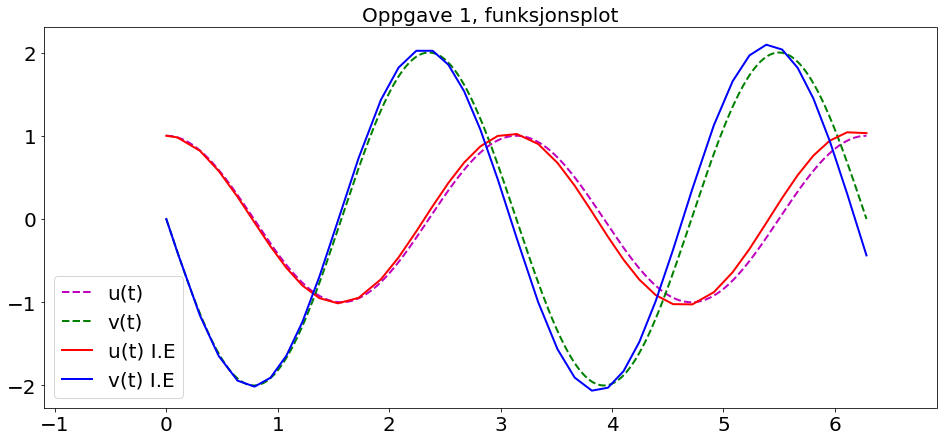

In [125]:
print("Oppgave 1")
def f1(t, y):
    # y[0] = u, y[1] = v
    return np.array([y[1], -4 * y[0]])

y0 = np.array([1, 0])
t0 = 0
tend = 2 * np.pi
h0 = 0.1
tol = 1e-1 # 1e-2 gir så og si overlapp.
T, Y, stats = ImprovedEuler(t0, tend, y0, f1, h0, tol)


print("Antall iterasjoner =", stats['iter'])
print("Antall skritt =", stats['steps'])
print("Antall funksjonskall =", stats['fevals'])
print("Antall skritt forkastet =", stats['rejects'])
plt.figure("Oppgave 1, funksjonsplot")
t = np.linspace(0, tend, 1000)
u = np.cos(2 * t)
v = -2 * np.sin(2 * t)
plt.plot(t, u, 'm--', label="u(t)")
plt.plot(t, v, 'g--', label="v(t)")
plt.plot(T, Y[:, 0], 'r-', label="u(t) I.E")
plt.plot(T, Y[:, 1], 'b-', label="v(t) I.E")
plt.xlim(-1.1, 1.1 * tend)
ymin = 1.1 * np.min([np.min(u), np.min(v), np.min(Y)])
ymax = 1.1 * np.max([np.max(u), np.max(v), np.max(Y)])
plt.ylim(ymin, ymax)
plt.title("Oppgave 1, funksjonsplot")
plt.legend(loc='lower left')
plt.show()



Oppgave 2
Antall iterasjoner = 631
Antall skritt = 621
Antall funksjonskall = 1253
Antall skritt forkastet = 10


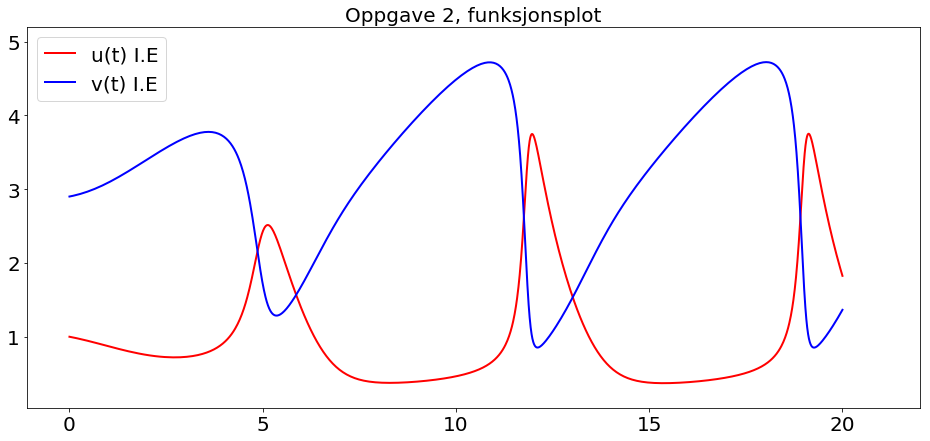

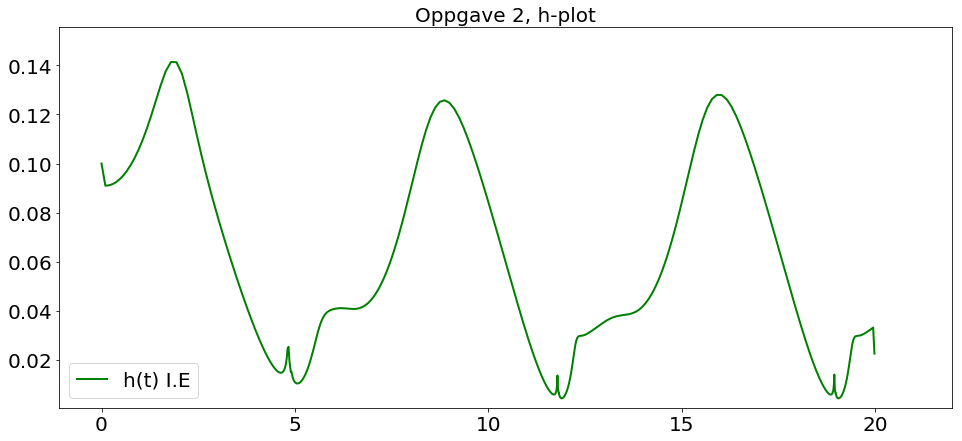

In [126]:
print("Oppgave 2")
def f1(t, y):
    # y[0] = u, y[1] = v
    return np.array([1 + y[0] ** 2 * y[1] - 4 * y[0], 3 * y[0] - y[0] ** 2 * y[1]])

y0 = np.array([1, 2.9])
t0 = 0
tend = 20
h0 = 0.1
tol = 1e-3
T, Y, stats = ImprovedEuler(t0, tend, y0, f1, h0, tol) # alfa = 0.9 er defulten



print("Antall iterasjoner =", stats['iter'])
print("Antall skritt =", stats['steps'])
print("Antall funksjonskall =", stats['fevals'])
print("Antall skritt forkastet =", stats['rejects'])
plt.figure("Oppgave 2, funksjonsplot")
plt.plot(T, Y[:, 0], 'r-', label="u(t) I.E")
plt.plot(T, Y[:, 1], 'b-', label="v(t) I.E")
plt.xlim(-1.1, 1.1 * tend)
plt.ylim(0.1 * np.min(Y), 1.1 * np.max(Y))
plt.title("Oppgave 2, funksjonsplot")
plt.legend(loc='upper left')
plt.show()

H = np.zeros(len(T) - 1)
for i in range(len(T)-1):
    H[i] = T[i + 1] - T[i]
plt.figure("Oppgave 2, h-plot")
plt.plot(T[:-1], H, 'r-', label="h(t) I.E", color='g')
plt.xlim(-1.1, 1.1 * T[-2])
plt.ylim(0.1 * np.min(H), 1.1 * np.max(H))
plt.title("Oppgave 2, h-plot")
plt.legend(loc='lower left')
plt.show()